# 데이터 로딩

In [1]:
import pandas as pd
![ ! -f  plc1.csv ]&&wget http://j.finfra.com/_file/plc1.csv
plc=pd.read_csv("plc1.csv")

--2021-02-01 07:25:59--  http://j.finfra.com/_file/plc1.csv
Resolving j.finfra.com (j.finfra.com)... 211.252.85.187
Connecting to j.finfra.com (j.finfra.com)|211.252.85.187|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6297 (6.1K) [text/csv]
Saving to: ‘plc1.csv’

plc1.csv            100%[===================>]   6.15K  --.-KB/s    in 0s      

2021-02-01 07:25:59 (543 MB/s) - ‘plc1.csv’ saved [6297/6297]



# 결측치 처리
* cf) https://rfriend.tistory.com/260

In [2]:
plc.head

<bound method NDFrame.head of            Date      Time  Sensor1  Sensor2  Sensor3  Sensor4    State
0    2018.12.01  09:00:00      6.6      2.9      4.6      1.3  warning
1    2018.12.01  09:00:01      6.4      2.9      4.3      1.3  warning
2    2018.12.01  09:00:02      6.4      3.2      5.3      2.3     good
3    2018.12.01  09:00:03      6.3      2.8      5.1      1.5     good
4    2018.12.01  09:00:04      6.1      3.0      4.6      1.4  warning
..          ...       ...      ...      ...      ...      ...      ...
145  2018.12.01  09:02:45      6.4      3.2      4.5      1.5  warning
146  2018.12.01  09:02:46      6.5      3.2      5.1      2.0     good
147  2018.12.01  09:02:47      5.3      3.7      1.5      0.2   faulty
148  2018.12.01  09:02:48      5.8      2.6      4.0      1.2  warning
149  2018.12.01  09:02:49    999.0      3.2      4.8      1.8  warning

[150 rows x 7 columns]>

In [6]:
plc.isnull().sum()

Date       0
Time       0
Sensor1    0
Sensor2    0
Sensor3    0
Sensor4    0
State      0
dtype: int64

In [7]:

plc['Sensor3']=plc['Sensor3'].fillna(0)
plc['Sensor1']=plc['Sensor1'].fillna(0)

plc.isnull().sum()


Date       0
Time       0
Sensor1    0
Sensor2    0
Sensor3    0
Sensor4    0
State      0
dtype: int64

In [8]:
plc.head


<bound method NDFrame.head of            Date      Time  Sensor1  Sensor2  Sensor3  Sensor4    State
0    2018.12.01  09:00:00      6.6      2.9      4.6      1.3  warning
1    2018.12.01  09:00:01      6.4      2.9      4.3      1.3  warning
2    2018.12.01  09:00:02      6.4      3.2      5.3      2.3     good
3    2018.12.01  09:00:03      6.3      2.8      5.1      1.5     good
4    2018.12.01  09:00:04      6.1      3.0      4.6      1.4  warning
..          ...       ...      ...      ...      ...      ...      ...
145  2018.12.01  09:02:45      6.4      3.2      4.5      1.5  warning
146  2018.12.01  09:02:46      6.5      3.2      5.1      2.0     good
147  2018.12.01  09:02:47      5.3      3.7      1.5      0.2   faulty
148  2018.12.01  09:02:48      5.8      2.6      4.0      1.2  warning
149  2018.12.01  09:02:49    999.0      3.2      4.8      1.8  warning

[150 rows x 7 columns]>

# 이상치 처리(Outlier Dection)
* [IQR 방법](https://wikidocs.net/89340)
  - IQR(InterQuartile Range)
  - IQR = 3 사분위 + 1 사분위


In [9]:
plc.describe()


,Sensor1,Sensor2,Sensor3,Sensor4
count,150.000000,150.000000,150.000000,150.000000
mean,12.422000,3.057333,3.708000,1.199333
std,81.100006,0.435866,1.796997,0.762238
min,0.000000,2.000000,0.000000,0.100000
25%,5.100000,2.800000,1.525000,0.300000
50%,5.800000,3.000000,4.300000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,999.000000,4.400000,6.900000,2.500000


In [10]:
quartile_1 = plc["Sensor1"].quantile(0.25)
quartile_3 = plc["Sensor1"].quantile(0.75) 
IQR= quartile_3 - quartile_1
search_df = plc[ (plc['Sensor1'] < (quartile_1 - 1.5 * IQR)) 
                | (plc['Sensor1'] > (quartile_3 + 1.5 * IQR))
                ]

In [11]:
search_df

,Date,Time,Sensor1,Sensor2,Sensor3,Sensor4,State
37,2018.12.01,09:00:37,0.0,3.3,4.7,1.6,warning
149,2018.12.01,09:02:49,999.0,3.2,4.8,1.8,warning


In [12]:
plc=plc.drop(search_df.index, axis=0)

In [13]:
plc.shape

(148, 7)

# 컬럼 추출

In [14]:
x=plc.iloc[:,2:6].values
y_text=plc.iloc[:,6:7]
y_text

,State
0,warning
1,warning
2,good
3,good
4,warning
...,...
144,faulty
145,warning
146,good
147,faulty


# 1차 인코딩


In [15]:
sets=y_text.drop_duplicates()["State"].tolist()
encoder={k:v for v,k in enumerate(sets)}
y_num=[ encoder[i] for i in y_text["State"].tolist() ]
y_num[0:5]



[0, 0, 1, 1, 0]

# One-hot Encoding


In [16]:
import keras
y= keras.utils.to_categorical(y_num, len(sets))
y[0:5,:]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

# 기술통계

In [17]:
plc.describe()

,Sensor1,Sensor2,Sensor3,Sensor4
count,148.000000,148.000000,148.000000,148.000000
mean,5.839865,3.054730,3.693919,1.192568
std,0.832809,0.438199,1.805028,0.765061
min,4.300000,2.000000,0.000000,0.100000
25%,5.100000,2.800000,1.500000,0.300000
50%,5.800000,3.000000,4.250000,1.300000
75%,6.400000,3.325000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# Histgram

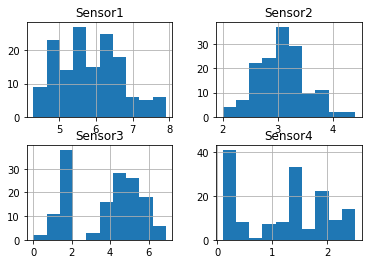

In [18]:
hist = plc.hist(bins=10)

# BoxPlot

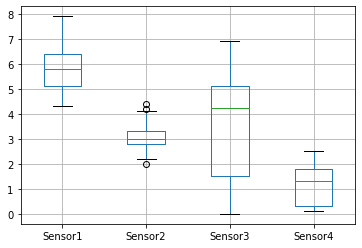

In [19]:
import matplotlib.pyplot as plt
plc.iloc[:,2:6].boxplot() 

# Pair Plot

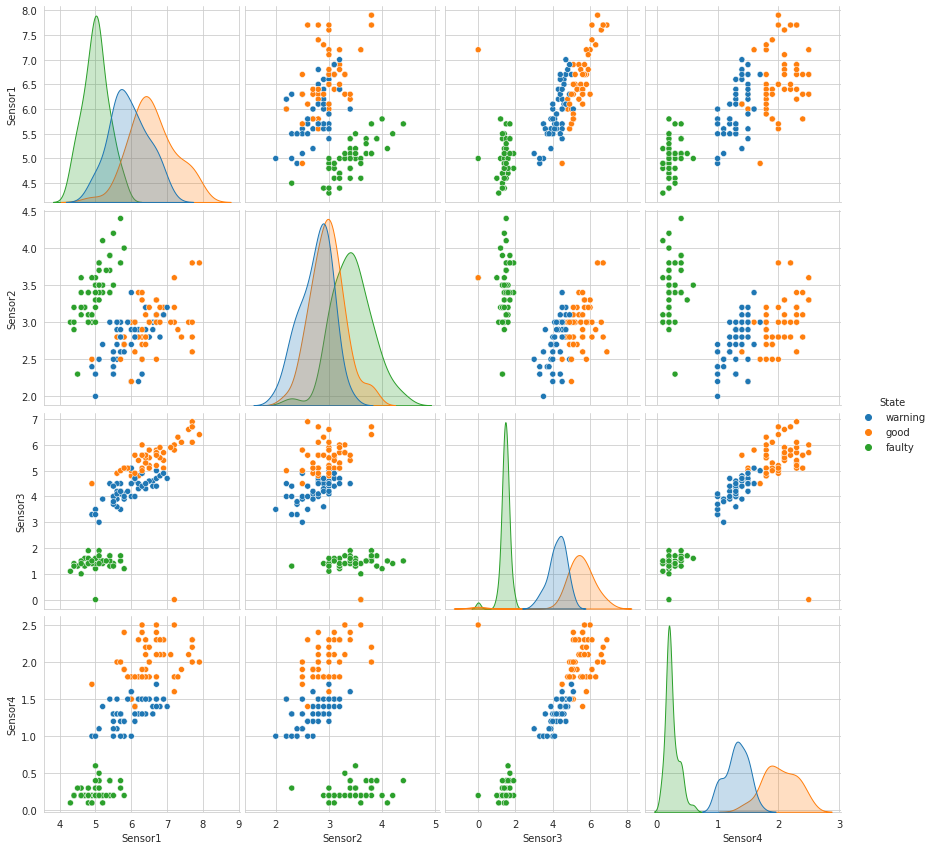

In [21]:
import seaborn as sns
import warnings
sns.set_style("whitegrid");
warnings.filterwarnings("ignore")

sns.pairplot(plc,hue="State",size=3);
plt.show()

# MLP Model

In [22]:
batch_size = 10
num_classes = 3
epochs = 200

In [23]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import optimizers

import matplotlib.pyplot as plt
def hist_view(hist):
  print('## training loss and acc ##')
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label='train loss')
  loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='center')

  acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
  acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
  acc_ax.set_ylabel('accuracy')
  acc_ax.legend(loc='center right')

  plt.show()

In [24]:
x=plc.iloc[:,2:6].values
y_text=plc.iloc[:,6:7]

sets=y_text.drop_duplicates()["State"].tolist()
encoder={k:v for v,k in enumerate(sets)}
y_num=[ encoder[i] for i in y_text["State"].tolist() ]




In [25]:
# iris.target → y
y= keras.utils.to_categorical(y_num, num_classes)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape


((103, 4), (45, 4), (103, 3), (45, 3))

In [26]:
from keras.layers import BatchNormalization, Dropout
from keras import regularizers

l2=regularizers.l2(l2=0.01)


model = Sequential()

model.add(Dense(6, activation='relu', input_shape=(4,)))
model.add(BatchNormalization())

model.add(Dense(4, activation='relu',kernel_regularizer=l2))
model.add(Dropout(0.2))

model.add(Dense(4, activation='relu',kernel_regularizer='l1'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 30        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 28        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 1

In [27]:
adam=optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


In [28]:
# batch_size,epochs
hist=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))



## training loss and acc ##


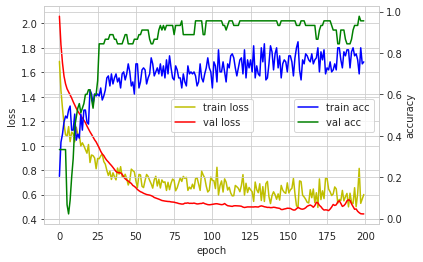

Test loss: 0.4420098066329956
Test accuracy: 0.9555555582046509


In [29]:
hist_view(hist)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [30]:
decoder = {k:v for k,v in enumerate( sets )}
decoder

{0: 'warning', 1: 'good', 2: 'faulty'}

In [31]:
r=np.argmax(model.predict(x_test[:10,:]), axis=-1)
[decoder[i] for i in r]

['warning',
 'warning',
 'warning',
 'warning',
 'warning',
 'good',
 'good',
 'faulty',
 'warning',
 'faulty']

# Model Save

## 1. Weigth 정보의 저장

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
model.save("/content/drive/MyDrive/plt_model.h5")

## 2. 모델 구조 저장
* 모델은 Json파일로 저장되고 Weigth파일은 h5 형태로 저장

In [34]:
model_json = model.to_json()
with open("/content/drive/MyDrive/plt_model.json", "w") as json_file:
    json_file.write(model_json)


# Confusion Matrix


In [38]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [39]:
expected = np.argmax(y_test,axis=-1).tolist()
predicted = np.argmax(model.predict(x_test[:,:]), axis=-1)
results = confusion_matrix(expected, predicted)
print(results)

[[12  1  0]
 [ 0 16  1]
 [ 0  0 15]]


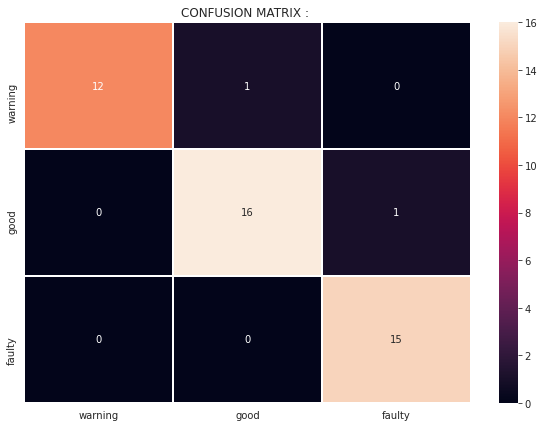

In [37]:
# fail나면 root계정에서  "pip install seaborn" 명령 실행할 것. 

import seaborn as sn

df_cm = pd.DataFrame(results, range(3),range(3))
plt.figure(figsize = (10,7))
plt.title("CONFUSION MATRIX : ")
# plt.ylabel('True Label')
# plt.xlabel('Predicted label')
sn.heatmap(df_cm, annot=True,xticklabels=sets, yticklabels=sets,fmt="d",linewidths=.5)